In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
import seaborn as sns
import gc
import tensorflow_probability as tfp

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/Datasets/Netflix Movies Recommendation/processed.csv')

In [ ]:
df

,userId,rating,movieId
0,1488844,3.0,1
1,822109,5.0,1
2,885013,4.0,1
3,30878,4.0,1
4,823519,3.0,1
...,...,...,...
100480502,1790158,4.0,17770
100480503,1608708,3.0,17770
100480504,234275,1.0,17770
100480505,255278,4.0,17770


In [ ]:
movieIndex = df.groupby("movieId").count().sort_values(by="rating",ascending=False)[0:1000].index
df2 = df[df.movieId.isin(movieIndex)]
df2.count()

userId     62838505
rating     62838505
movieId    62838505
dtype: int64

In [ ]:
userIndex = df2.groupby("userId").count().sort_values(by="rating",ascending=False).sample(n=1000, random_state=2018).index
df3 = df2[df2.userId.isin(userIndex)]
df3.count()

userId     133172
rating     133172
movieId    133172
dtype: int64

In [ ]:
movies = df3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1

users = df3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1

ratingDF = df3.merge(moviesDF,left_on='movieId',right_on='originalMovieId')
ratingDF.drop(labels='originalMovieId', axis=1, inplace=True)

ratingDF = ratingDF.merge(usersDF,left_on='userId',right_on='originalUserId')
ratingDF.drop(labels='originalUserId', axis=1, inplace=True)

ratingDF.head()

,userId,rating,movieId,newMovieId,newUserId
0,140736,5.0,28,1,1
1,140736,3.0,175,5,1
2,140736,5.0,191,6,1
3,140736,5.0,312,16,1
4,140736,5.0,483,30,1


In [ ]:
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  133172
Average number of ratings per user:  133.172


<Axes: xlabel='rating', ylabel='count'>

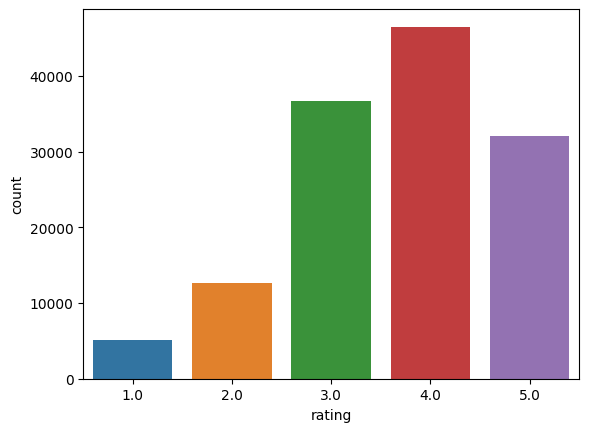

In [ ]:
sns.countplot(data = ratingDF, x = 'rating')

In [ ]:
ratingDF['rating_binary'] = ratingDF['rating'].apply(lambda x: 0.5 if x <= 3 else 1)

In [ ]:
ratingDF

,userId,rating,movieId,newMovieId,newUserId,rating_binary
0,140736,5.0,28,1,1,1.0
1,140736,3.0,175,5,1,0.5
2,140736,5.0,191,6,1,1.0
3,140736,5.0,312,16,1,1.0
4,140736,5.0,483,30,1,1.0
...,...,...,...,...,...,...
133167,1851206,5.0,14103,765,997,1.0
133168,1851206,5.0,16357,913,997,1.0
133169,1572399,4.0,12966,699,998,1.0
133170,2508177,1.0,14215,772,999,0.5


<Axes: xlabel='rating_binary', ylabel='count'>

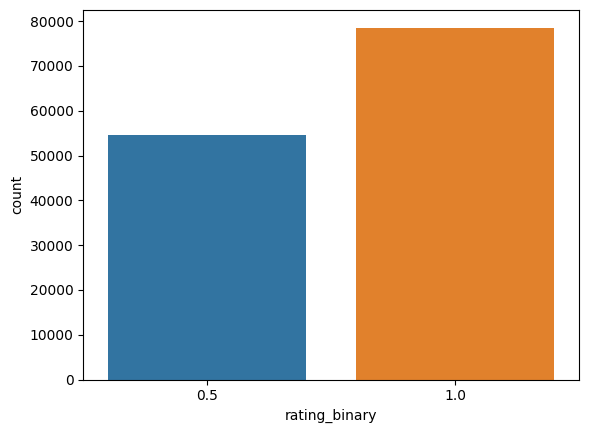

In [ ]:
sns.countplot(data = ratingDF, x = 'rating_binary')

In [ ]:
X_train, X_test = train_test_split(ratingDF, test_size = 0.10, random_state = 42)

In [ ]:
#X_train | X_val | X_test

In [ ]:
print(len(X_train), len(X_val), len(X_test))

119854 6659 13318


In [ ]:
#M X N matrix where M is users and N is movie. And the values in the matrix are ratings

In [ ]:
X_train['rating_binary'].value_counts()

1.0    70678
0.5    49176
Name: rating_binary, dtype: int64

In [ ]:
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[5]-1, row[4]-1] = row[6]

In [ ]:
ratings_train

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.5, 1. , 0. , ..., 0. , 1. , 1. ],
       [0.5, 1. , 0. , ..., 0.5, 0. , 1. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [ ]:
ratings_train.shape

(1000, 1000)

In [ ]:
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 11.99%


In [ ]:
ratings_validation = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_validation[row[5]-1, row[4]-1] = row[6]

In [ ]:
ratings_validation

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [ ]:
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.33%


In [ ]:
del df, df2, df3
gc.collect()

NameError: ignored

In [ ]:
class RBM():

  def __init__(self, input_size, output_size, learning_rate, epochs, batch_size):

    super().__init__()
    self.input_size = input_size   #D
    self.output_size = output_size #M
    self.batch_size = batch_size
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.errors = []

    self.weights = tf.Variable(tf.random.normal(shape = (input_size, output_size)) * 2 / np.sqrt(output_size))
    self.hidden_bias = tf.Variable(np.zeros([output_size], dtype=np.float32))
    self.visible_bias = tf.Variable(np.zeros([input_size], dtype=np.float32))

  def prob_hidden_given_visible(self, v_given, weights, hidden_bias):

    p_of_h_given_v = tf.nn.sigmoid(tf.linalg.matmul(v_given, weights) + hidden_bias)

    bernoulli_distribution = tfp.distributions.Bernoulli(probs = p_of_h_given_v)
    hidden_sample = bernoulli_distribution.sample()

    hidden_sample = tf.cast(hidden_sample, dtype=tf.float32)

    return hidden_sample

  def prob_visible_given_hidden(self, h_given, weights, visible_bias):

    p_of_v_given_h = tf.nn.sigmoid(tf.linalg.matmul(h_given, tf.transpose(weights)) + visible_bias)

    bernoulli_distribution = tfp.distributions.Bernoulli(probs = p_of_v_given_h)
    visible_sample = bernoulli_distribution.sample()

    return visible_sample

  def free_energy(self, v_given):  #loss function

    visible_bias_reshaped = tf.reshape(self.visible_bias, (self.input_size, 1))

    first_term = -tf.linalg.matmul(v_given, visible_bias_reshaped)
    first_term = tf.reshape(first_term, (-1,))

    second_term = -tf.reduce_sum(

        #tf.log(1 + tf.exp(tf.linalg.matmul(v_given, self.weights), self.hidden_bias))
        tf.nn.softplus(tf.linalg.matmul(v_given, self.weights) + self.hidden_bias), axis = 1

        )

    return first_term + second_term

  def cost(self, X_in):

    forward_hidden = tf.nn.sigmoid(tf.linalg.matmul(X_in, self.weights) + self.hidden_bias)
    logits = tf.linalg.matmul(forward_hidden, tf.transpose(self.weights) + self.visible_bias)
    op_cost = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = X_in, logits = logits))

    return op_cost

  def fit(self, X_in):

    #v0 = self.X_in batch data

    for epoch in range(self.epochs):

      for start, end in zip(range(0, len(X_in) + self.batch_size, self.batch_size), range(self.batch_size, len(X_in) + self.batch_size, self.batch_size)):

        v0 = X_in[start : end]

        h1 = self.prob_hidden_given_visible(v0, self.weights, self.hidden_bias)

        v1 = self.prob_visible_given_hidden(h1, self.weights, self.visible_bias)

        v1 = tf.cast(v1, dtype = tf.float32)

        with tf.GradientTape() as tape:

          objective = tf.math.reduce_mean(self.free_energy(v0)) - tf.math.reduce_mean(self.free_energy(v1)) #free energy loss F(v) - F(v')

          #rbm_gradients = tape.gradient(objective, RBM.trainable_variables)
          #tf.keras.optimizers.Adam(learning_rate = self.learning_rate).apply_gradients(zip(rbm_gradients, RBM.trainable_variables))

          tf.keras.optimizers.Adam(learning_rate = self.learning_rate).minimize(objective, var_list = [self.weights, self.hidden_bias, self.visible_bias], tape = tape)

      #c = self.cost(v0)

      c = tf.math.reduce_mean(tf.square(v0 - v1))

      self.errors.append(c)

      print('epoch: ', epoch + 1, 'reconstruction error', np.asarray(c)) #reconstruction error -> mean squared error

  def show_fig(self):

    fig = plt.subplots(figsize = (8, 6))
    plt.plot(self.errors)
    plt.ylabel('Reconstruction Error (MSE)')
    plt.xlabel('Epoch')
    plt.show()

  def rbm_output(self, X_in):

    out = tf.nn.sigmoid(tf.matmul(X_in, self.weights) + self.hidden_bias)
    hiddenGen = self.prob_hidden_given_visible(X_in, self.weights, self.hidden_bias)
    visibleGen = self.prob_visible_given_hidden(hiddenGen, self.weights, self.visible_bias)

    return out, visibleGen, hiddenGen

In [ ]:
inputX = ratings_train
inputX = inputX.astype(dtype=np.float32)
rbm = RBM(1000, 1000, 0.3, 50, 200)

In [ ]:
err = rbm.fit(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

epoch:  1 reconstruction error 0.09801375
epoch:  2 reconstruction error 0.08384375
epoch:  3 reconstruction error 0.05660375
epoch:  4 reconstruction error 0.03829375
epoch:  5 reconstruction error 0.03013375
epoch:  6 reconstruction error 0.02114375
epoch:  7 reconstruction error 0.01766875
epoch:  8 reconstruction error 0.01241875
epoch:  9 reconstruction error 0.01098875
epoch:  10 reconstruction error 0.00926875
epoch:  11 reconstruction error 0.00843875
epoch:  12 reconstruction error 0.00799375
epoch:  13 reconstruction error 0.00734375
epoch:  14 reconstruction error 0.00670375
epoch:  15 reconstruction error 0.00672375
epoch:  16 reconstruction error 0.00562875
epoch:  17 reconstruction error 0.00563375
epoch:  18 reconstruction error 0.00517375
epoch:  19 reconstruction error 0.00475875
epoch:  20 reconstruction error 0.00515375
epoch:  21 reconstruction error 0.00450375
epoch:  22 reconstruction error 0.00479875
epoch:  23 reconstruction error 0.00438375
epoch:  24 reconstru

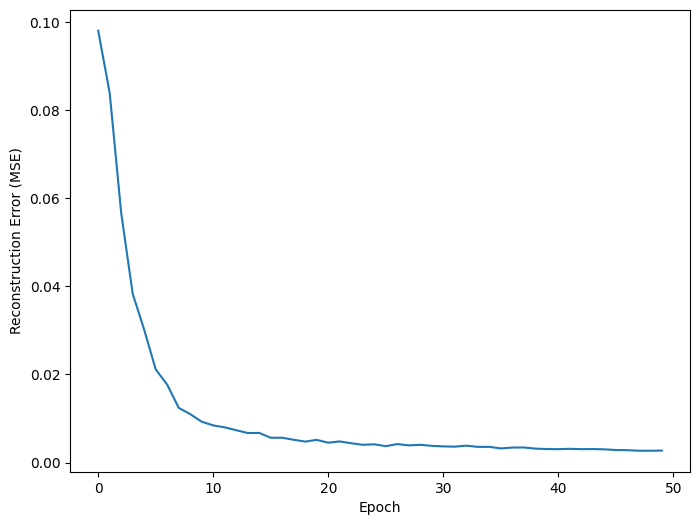

In [ ]:
rbm.show_fig()

In [ ]:
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)
finalOutput_validation, reconstructedOutput_validation, _ = rbm.rbm_output(inputValidation)

In [ ]:
inputValidation

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]], dtype=float32)

In [ ]:
finalOutput_validation

<tf.Tensor: shape=(1000, 1000), dtype=float32, numpy=
array([[1.9962419e-20, 1.4613972e-18, 3.7364915e-20, ..., 7.7708248e-16,
        3.7210076e-13, 1.4270857e-12],
       [2.8067412e-08, 3.6666773e-15, 4.7464222e-17, ..., 1.1766581e-14,
        4.4316520e-13, 4.0513217e-13],
       [1.2120189e-15, 8.6177362e-14, 8.0859490e-19, ..., 1.8260099e-18,
        6.2449839e-13, 1.3349761e-08],
       ...,
       [5.1362912e-07, 4.5801844e-05, 8.6978680e-06, ..., 9.2580160e-07,
        3.5191690e-05, 9.9884364e-06],
       [5.1362912e-07, 4.5801844e-05, 8.6978680e-06, ..., 9.2580160e-07,
        3.5191690e-05, 9.9884364e-06],
       [2.0099594e-07, 3.1640859e-05, 1.8939110e-06, ..., 5.9079349e-07,
        3.3572676e-05, 3.7629090e-06]], dtype=float32)>

In [ ]:
reconstructedOutput_validation

<tf.Tensor: shape=(1000, 1000), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
predictionsArray = reconstructedOutput_validation
predictionsArray = tf.reshape(predictionsArray, shape = [-1])
non_zero_ratings = ratings_validation.nonzero()
non_zero_ratings = np.concatenate([non_zero_ratings[0], non_zero_ratings[1]])
ratings_validation = tf.reshape(ratings_validation, shape = [-1])

In [ ]:
non_zero_ratings

array([  0,   0,   0, ..., 832, 858, 978])

In [ ]:
pred_validation = []

for element in non_zero_ratings:

  pred_validation.append(predictionsArray[element])

In [ ]:
pred_validation = np.array(pred_validation)
pred_validation

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

In [ ]:
actual_validation = []

for element in non_zero_ratings:

  actual_validation.append(ratings_validation[element])

In [ ]:
actual_validation = np.array(actual_validation)
actual_validation

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
pred_validation.shape

(26636,)

In [ ]:
actual_validation.shape

(26636,)

In [ ]:
from sklearn.metrics import mean_squared_error

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 0.12202470340892026


In [ ]:
print('Root mean squared error using RBM prediction:', np.sqrt(rbm_prediction))

Root mean squared error using RBM prediction: 0.34932034496851205


In [ ]:
reconstructedX = np.array(reconstructedX)

In [ ]:
reconstructedX[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [ ]:
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[5]-1, row[4]-1] = row[6]

In [ ]:
sparsity = float(len(ratings_test.nonzero()[0]))
sparsity /= (ratings_test.shape[0] * ratings_test.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.67%


In [ ]:
# Predict ratings for test set
inputTest = ratings_test
inputTest = inputTest.astype(np.float32)
finalOutput_test, reconstructedOutput_test, _ = rbm.rbm_output(inputTest)

In [ ]:
testpredictionsArray = reconstructedOutput_test
testpredictionsArray = tf.reshape(testpredictionsArray, shape = [-1])
non_zero_ratings_test = ratings_test.nonzero()
non_zero_ratings_test = np.concatenate([non_zero_ratings_test[0], non_zero_ratings_test[1]])
ratings_test = tf.reshape(ratings_test, shape = [-1])

In [ ]:
pred_test = []

for element in non_zero_ratings_test:

  pred_test.append(testpredictionsArray[element])

In [ ]:
pred_test = np.array(pred_test)
pred_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
actual_test = []

for element in non_zero_ratings_test:

  actual_test.append(ratings_test[element])

In [ ]:
actual_test = np.array(actual_test)
actual_test

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
pred_test.shape

(13318,)

In [ ]:
actual_test.shape

(13318,)

In [ ]:
from sklearn.metrics import mean_squared_error

rbm_prediction_test = mean_squared_error(pred_test, actual_test)
print('Mean squared error using RBM prediction:', rbm_prediction_test)
print('Root mean squared error using RBM prediction:', np.sqrt(rbm_prediction_test))

Mean squared error using RBM prediction: 0.036022676077489116
Root mean squared error using RBM prediction: 0.1897964069140644


In [ ]:
pred_test.shape

(13318,)

In [ ]:
pred_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)